In [76]:
# importing the necessary packages
import itertools
import operator
import seaborn as sns
import pandas as pd
import numpy as np
import time
import pickle
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.colors
from pandarallel import pandarallel
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from langdetect import detect
import gensim
import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import re

import warnings
warnings.filterwarnings('ignore')
import lightfm
from lightfm.data import Dataset
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM

In [81]:
def time_now():
    now = time.ctime()
    cnvtime = time.strptime(now)
    print(time.strftime("%Y/%m/%d %H:%M", cnvtime))

In [19]:
num_processors = multiprocessing.cpu_count()

In [4]:
pandarallel.initialize(progress_bar=True, nb_workers=num_processors-1, use_memory_fs=False)

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


#### Data Prep 
*** No need for run the codes below again ***

#### Lyrics data

In [448]:
# df_lyrics_0 = pd.read_csv('df_lyrics_0.csv')
# df_lyrics_1 = pd.read_csv('df_lyrics_1.csv')
# df_lyrics_2 = pd.read_csv('df_lyrics_2.csv')
# df_lyrics_3 = pd.read_csv('df_lyrics_3.csv')
# df_lyrics_4 = pd.read_csv('df_lyrics_4.csv')
# df_lyrics_5 = pd.read_csv('df_lyrics_5.csv')

In [449]:
# No need for run again
# df_lyrics = pd.concat([df_lyrics_0, df_lyrics_1, df_lyrics_2, df_lyrics_3, df_lyrics_4, df_lyrics_5], axis=0)

In [450]:
df_lyrics = df_lyrics.reset_index(drop=True)

In [451]:
df_lyrics['len_lyric'] = df_lyrics['lyric'].apply(lambda x: len(x))

(0.0, 5000.0)

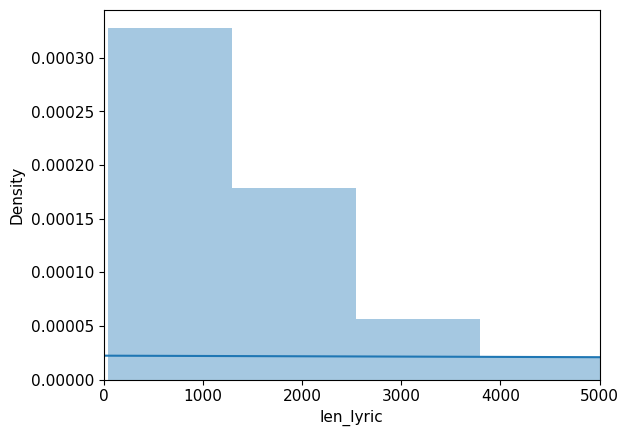

In [452]:
sns.distplot(df_lyrics['len_lyric'],bins=2000)
plt.xlim(0,5000)

In [453]:
len(df_lyrics[df_lyrics['len_lyric'] < 4000])

21409

In [454]:
def lang_detect(x):
    try:
        return detect(x)
    except:
        return'--'

In [250]:
df_lyrics = df_lyrics[df_lyrics['len_lyric'] < 4000]

In [456]:
df_lyrics['UID'] = df_lyrics['track'] + '_' + df_lyrics['artist']

In [457]:
df_lyrics = df_lyrics.drop_duplicates(subset='UID').reset_index(drop=True)

In [458]:
df_lyrics['language'] = df_lyrics['lyric'].apply(lambda x: lang_detect(x))

In [459]:
df_lyrics = df_lyrics[df_lyrics['language']=='en'].reset_index(drop=True)

In [461]:
### df_lyrics.to_csv('df_lyrics.csv', index=False)

#### Features data

In [436]:
df_features = pd.read_csv('230224_Tracks_attribute_list.csv')
df_features_2 = pd.read_csv('230227_Tracks_attribute_list.csv')

In [437]:
df_features = pd.concat([df_features, df_features_2], axis=0).reset_index(drop=True)

In [440]:
df_features = df_features[['track_id', 'Search_name','artists', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'popularity']]

In [463]:
df_features['UID'] = df_features['Search_name'] + '_' + df_features['artists']

In [464]:
df_features = df_features.drop_duplicates(subset=['UID'])

In [469]:
df_features = df_features[df_features['UID'].isin(df_lyrics['UID'].tolist())]

In [3]:
df_hist = pd.read_csv(r'spotify_dataset.csv', on_bad_lines='skip')

In [4]:
df_hist.columns = ['user_id','artistname','trackname','playlistname']

In [470]:
df_hist['UID'] = df_hist['trackname'] + '_'+df_hist['artistname']

In [471]:
df_merge = pd.merge(df_hist, df_features,on='UID', how='left')

In [472]:
df_merge = df_merge[~df_merge['track_id'].isnull()]

In [473]:
df_merge = df_merge.reset_index(drop=True)

In [474]:
len(df_merge['UID'].unique())

15711

In [475]:
len(df_features['UID'])

15711

In [476]:
len(df_merge)

151404

In [13]:
len(df_merge['user_id'].unique())

12215

In [477]:
### df_merge.to_csv('df_merge.csv', index=False)

In [478]:
### df_features.to_csv('df_features.csv', index=False)

#### *** Run code from here

In [7]:
df_merge = pd.read_csv('df_merge.csv')
df_features = pd.read_csv('df_features.csv')
df_lyrics = pd.read_csv('df_lyrics.csv')

## Data Overview

* df_merge: features data + customer history data (151404 songs listening history by 12,215 listeners)
* df_features: songs feature data (15711 songs)
* df_lyrics: songs feature data (15711 songs)

### Listening history
Obtained by Kaggle dataset.

### Features:
Extracted by Spotify’s API 
Features used for this analysis are:

* Danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
* Acousticness: A measure from 0.0 to 1.0 of whether the track is acoustic.
* Energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.
* Instrumentalness: Predicts whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.
* Liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
* Loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track. Values typical range between -60 and 0 db.
* Speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.
* Tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
* Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

### Lyrics:  
* Extracted by Genius API. exclude very long songs(songs >4000 words)
* Only used songs with English lyrics. Detected using langdetect package.

# EDA

### Standardize features

In [8]:
numeric_cols = ['danceability', 'energy', 'key',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'popularity']

In [9]:
scaler = StandardScaler()

In [10]:
scaler.fit(df_features[numeric_cols])

StandardScaler()

In [11]:
df_features[numeric_cols] = scaler.transform(df_features[numeric_cols])

### Popular songs 
How many people listened to the song? - includes only unique listens per user.

<Axes: ylabel='UID'>

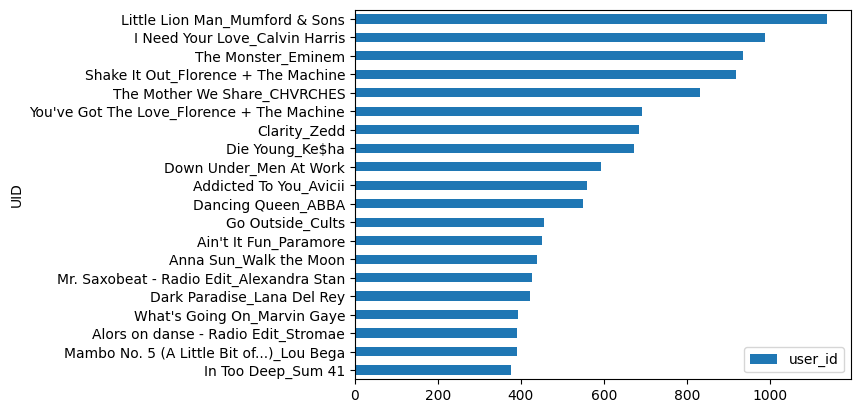

In [12]:
gb_popsongs = pd.DataFrame(df_merge.drop_duplicates(subset=['trackname','user_id']).\
groupby(['UID']).count()['user_id']).sort_values(by='user_id', ascending=False)
gb_popsongs.head(20).sort_values(by='user_id', ascending=True).plot.barh()

In [13]:
gb_popsongs.columns = ['user_numbers']

In [14]:
gb_popsongs = gb_popsongs.reset_index()

### Sound features of top popularity songs

In [15]:
df_features = pd.merge(df_features, gb_popsongs, on='UID',how='left')

In [16]:
top_10songs = df_features.sort_values(by='user_numbers', ascending=False).head(10)

In [17]:
acoustic_features = ['danceability', 'energy', 'key','loudness', 
'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo']

In [18]:
top_10songs = top_10songs[acoustic_features + ['UID']]

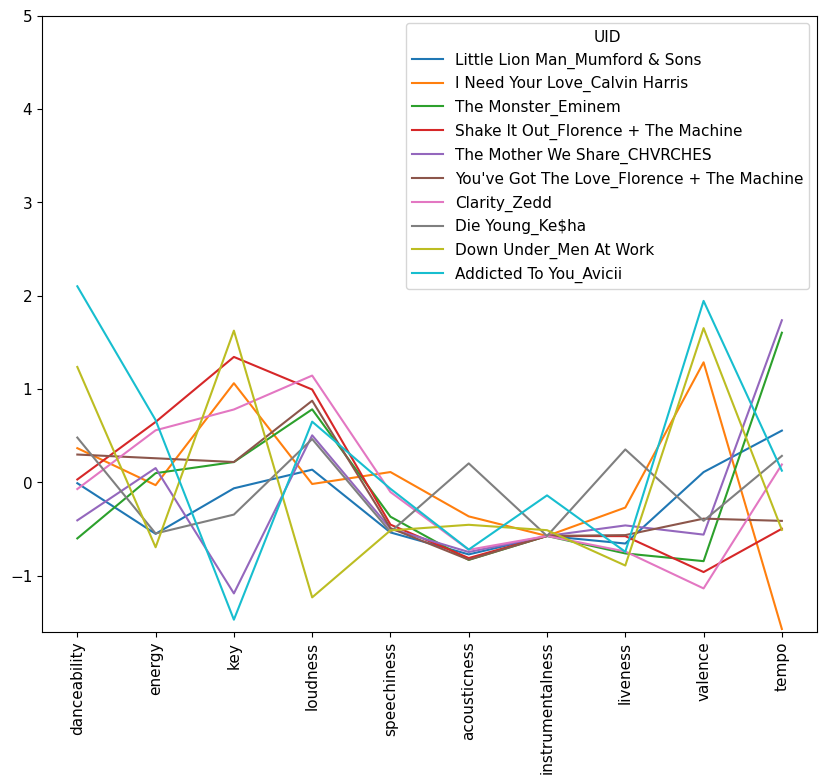

In [19]:
plt.rcParams["font.size"] = 11
top_10songs.set_index('UID').T.plot(figsize=(10,8))
plt.xticks(np.arange(len(acoustic_features)), acoustic_features,rotation= 90)
plt.ylim(-1.6, 5)
plt.show()

Top songs do not necessarily share the same acoustic features.  
Only instrumentalness tends to be lower when the song is popular.

### Correlation between acoustic_features vs. # of users listened the songs.

<Axes: >

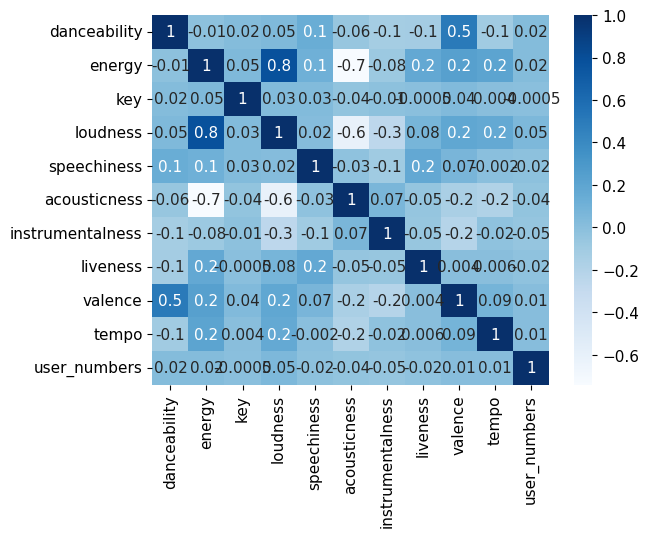

In [20]:
sns.heatmap(df_features[acoustic_features+['user_numbers']].corr(), cmap='Blues', fmt='.1g', annot=True)

Loudness & energy shows a high correlation. It could be combined together in feature engineering.

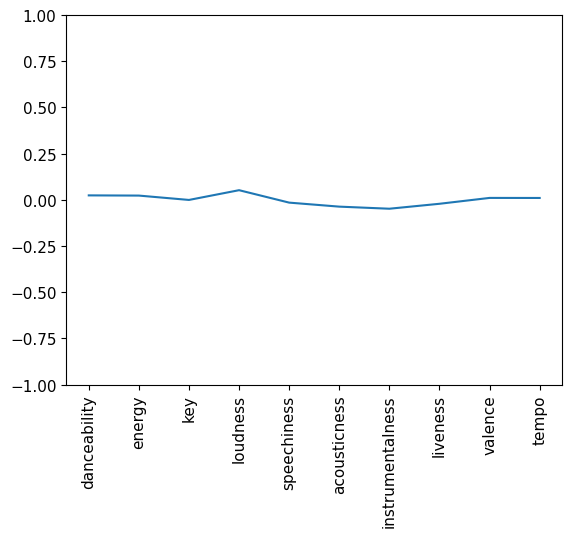

In [21]:
df_features[acoustic_features+['user_numbers']].corr()['user_numbers'][acoustic_features].plot()
plt.xticks(np.arange(len(acoustic_features)), acoustic_features,rotation= 90)
plt.ylim(-1, 1)
plt.show()

No tendency between acoustic features and # of listeners. (Preference depends on users.)

### Feature selection

Want to determine the most important features. Creating histogram to see the distribution of acoustic_features.

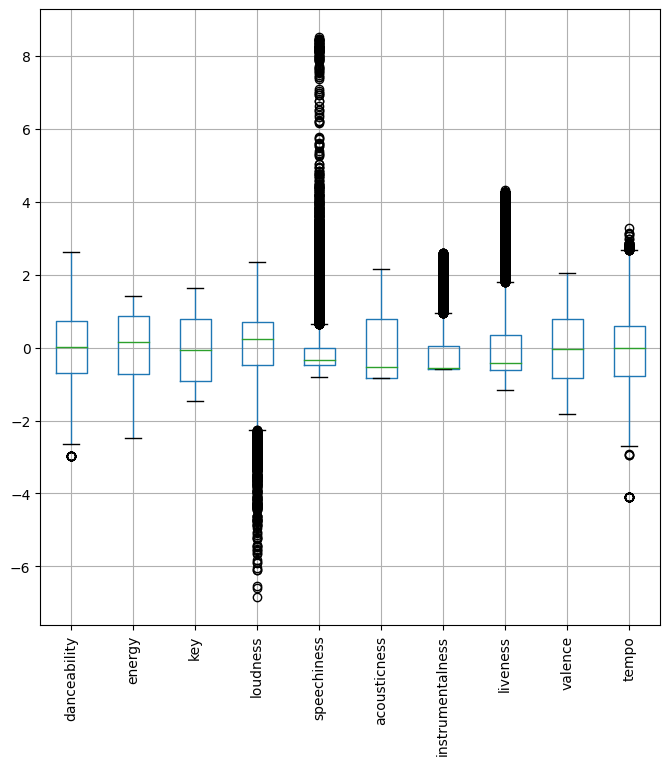

In [22]:
plt.rcParams["font.size"] = 10
df_features[acoustic_features].boxplot(figsize=(8,8))
plt.xticks(rotation= 90)
plt.show()

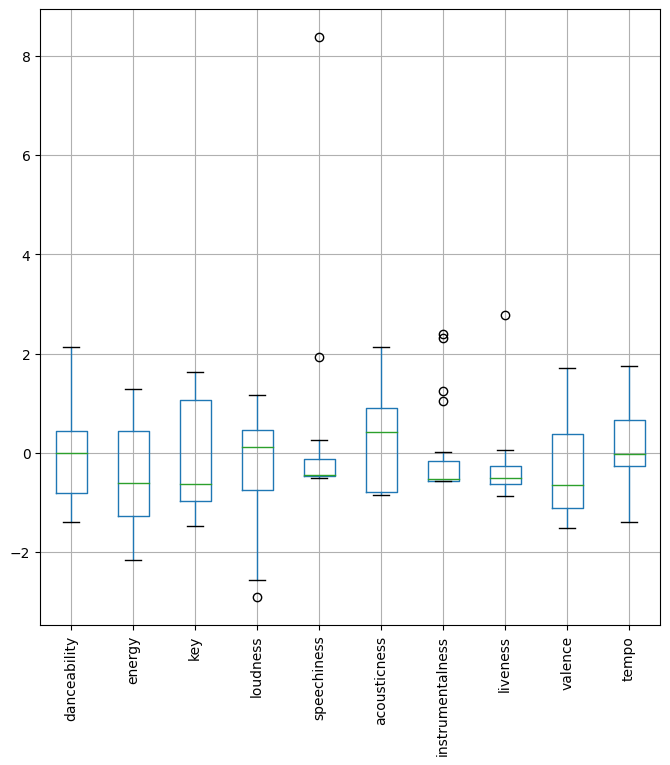

In [23]:
plt.rcParams["font.size"] = 10
df_features[acoustic_features].head(20).boxplot(figsize=(8,8))
plt.xticks(rotation= 90)
plt.show()

Create k-means clusters based on distance. If specific acoustic features are equally distributed, the feature may not effectively work to separate the songs.

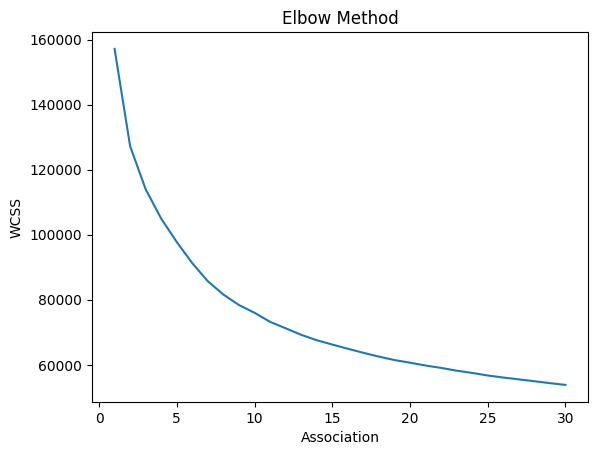

In [24]:
wcss = []

for i in range(1,31):
    kmeans = KMeans(n_clusters=i, init='k-means++',
                   max_iter=400, n_init=10, random_state=0)
    kmeans.fit(df_features[acoustic_features])
    wcss.append(kmeans.inertia_)

plt.plot(range(1,31), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS')
plt.show()

Based on the Elbow Method, 8 clusters might be good.

In [25]:
kmeans = KMeans(n_clusters=8, init='k-means++',
               max_iter=400, n_init=10, random_state=0)

In [26]:
kmeans.fit(df_features[acoustic_features])

KMeans(max_iter=400, n_init=10, random_state=0)

In [27]:
df_features['cluster'] = kmeans.labels_

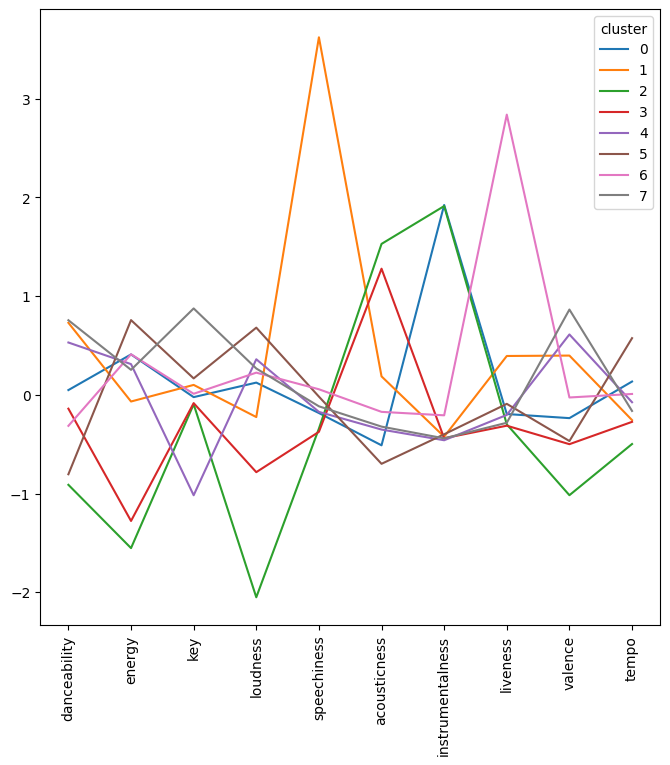

In [28]:
df_features.groupby('cluster').mean()[acoustic_features].T.plot(figsize=(8,8))
plt.xticks(np.arange(len(acoustic_features)), acoustic_features,rotation= 90)
plt.show()

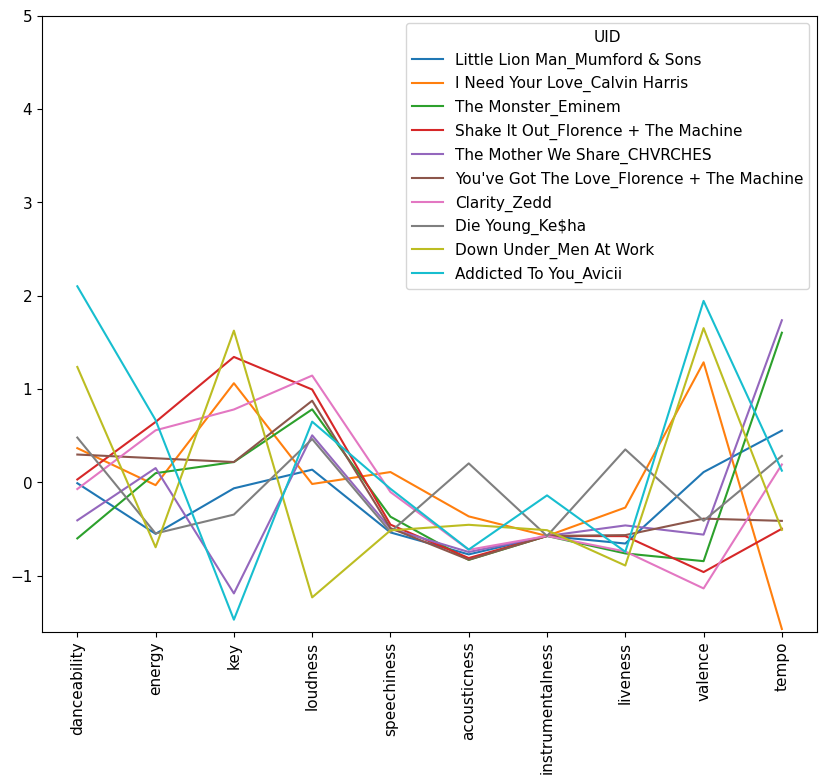

In [29]:
plt.rcParams["font.size"] = 11
top_10songs.set_index('UID').T.plot(figsize=(10,8))
plt.xticks(np.arange(len(acoustic_features)), acoustic_features,rotation= 90)
plt.ylim(-1.6, 5)
plt.show()

Decided to keep all acoustic features since there are no trends or similarities between features in the various clusters.

# Feature engineering

We want to add the semantic characteristics (lyrics) to the model.
This will be done by creating lyric topics through topic modeling, which will be added to each song. The probability of each topic cluster will be used as vectors. We will have 2 variations per model:
* Acoustic characteristics
* Acoustic characteristics + Semantic characteristics (Lyric topic)

### Combining high correlation item

Based on the EDA section, loudness and energy are highly correlated. Combine those features together.

In [30]:
df_features['loudness_energy'] = (df_features['loudness'] + df_features['energy'])/2

In [31]:
df_features['loudness_energy']

0        0.455222
1       -1.738526
2        0.500203
3       -0.809134
4       -0.438671
           ...   
15706    0.648494
15707   -0.182287
15708   -0.092585
15709   -1.926641
15710   -1.032982
Name: loudness_energy, Length: 15711, dtype: float64

In [32]:
scaler.fit(df_features[['loudness_energy']])
df_features[['loudness_energy']] = scaler.transform(df_features[['loudness_energy']])

In [33]:
df_features = df_features.drop(['loudness','energy'], axis=1)

In [34]:
df_merge = df_merge.drop(['loudness','energy'], axis=1)

In [35]:
df_merge = pd.merge(df_merge, df_features[['UID','loudness_energy']], on='UID', how='left')

In [60]:
acoustic_features  = ['danceability', 'key','loudness_energy', 
'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo']

In [57]:
df_merge.columns

Index(['user_id', 'artistname', 'trackname', 'playlistname', 'UID', 'track_id',
       'Search_name', 'artists', 'danceability', 'key', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'popularity', 'loudness_energy'],
      dtype='object')

### Topic modeling

Lyrics meaning clusters are created by NLP topic modeling technique.

### Data cleansing

In [34]:
df_lyrics['cleaned_lyric'] = df_lyrics.apply(lambda x: x['lyric'].replace(x['track'], '') , axis=1)

In [35]:
df_lyrics['cleaned_lyric'] = df_lyrics['cleaned_lyric'].apply(lambda x: x.split('Lyrics')[1])

In [36]:
df_lyrics['cleaned_lyric'] = df_lyrics['cleaned_lyric'].str.replace(r'\n', ' ')

In [37]:
df_lyrics['cleaned_lyric'] = df_lyrics['cleaned_lyric'].\
apply(lambda x: re.sub(r'\[[^\[|\]]*]', '', str(x)))

### Deleting stop words / Create tokens & n_grams for LDA

In [38]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [39]:
lyrics = df_lyrics['cleaned_lyric'].tolist()
lyrics_tokens = list(sent_to_words(lyrics))

In [40]:
%%time
lyrics_bigram = gensim.models.Phrases(lyrics_tokens, min_count=1, threshold=1)
lyrics_trigram = gensim.models.Phrases(lyrics_bigram[lyrics_tokens], threshold=1)
lyrics_bigram_mod = gensim.models.phrases.Phraser(lyrics_bigram)
lyrics_trigram_mod = gensim.models.phrases.Phraser(lyrics_trigram)

CPU times: user 3min 28s, sys: 6.5 s, total: 3min 34s
Wall time: 3min 37s


In [16]:
%%time

stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for i, sent in enumerate(texts):
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        if i % 100 == 0:
            print(i)
            time_now()
    return texts_out

CPU times: user 858 µs, sys: 1.96 ms, total: 2.81 ms
Wall time: 1.76 ms


In [42]:
%%time

lyrics_tokens = list(sent_to_words(lyrics))

# Remove Stop Words
lyrics_tokens_nostops = remove_stopwords(lyrics_tokens)
# Create n-grams
lyrics_words_bigrams = [lyrics_bigram_mod[doc] for doc in lyrics_tokens_nostops]
lyrics_words_trigrams = [lyrics_trigram_mod[lyrics_bigram_mod[doc]] for doc in lyrics_tokens_nostops]

# Combine tokens and n-grams
lyrics_tokens_cobnined = lyrics_tokens_nostops + lyrics_words_bigrams + lyrics_words_trigrams

CPU times: user 4min 57s, sys: 15 s, total: 5min 12s
Wall time: 5min 19s


### Words lemmatization

In [12]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [13]:
nlp.max_length = 2000000

In [59]:
import pickle
pickle.dump(lyrics_tokens_cobnined, open('lyrics_tokens_combined.p', 'wb'))

In [2]:
import pickle

In [3]:
lyrics_tokens_cobnined = pickle.load(open('lyrics_tokens_combined.p', 'rb'))

In [7]:
len(lyrics_tokens_cobnined)

47133

In [20]:
%%time
# Lemmatize text keeping only noun, adj, vb, adv
lyrics_lemmatized = lemmatization(lyrics_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

0
2023/02/28 15:04
100
2023/02/28 15:04
200
2023/02/28 15:05
300
2023/02/28 15:05
400
2023/02/28 15:06
500
2023/02/28 15:06
600
2023/02/28 15:06
700
2023/02/28 15:07
800
2023/02/28 15:07
900
2023/02/28 15:07
1000
2023/02/28 15:08
1100
2023/02/28 15:08
1200
2023/02/28 15:09
1300
2023/02/28 15:09
1400
2023/02/28 15:09
1500
2023/02/28 15:10
1600
2023/02/28 15:10
1700
2023/02/28 15:10
1800
2023/02/28 15:11
1900
2023/02/28 15:11
2000
2023/02/28 15:11
2100
2023/02/28 15:12
2200
2023/02/28 15:12
2300
2023/02/28 15:13
2400
2023/02/28 15:13
2500
2023/02/28 15:14
2600
2023/02/28 15:14
2700
2023/02/28 15:14
2800
2023/02/28 15:15
2900
2023/02/28 15:15
3000
2023/02/28 15:16
3100
2023/02/28 15:17
3200
2023/02/28 15:17
3300
2023/02/28 15:17
3400
2023/02/28 15:18
3500
2023/02/28 15:18
3600
2023/02/28 15:19
3700
2023/02/28 15:19
3800
2023/02/28 15:19
3900
2023/02/28 15:20
4000
2023/02/28 15:20
4100
2023/02/28 15:21
4200
2023/02/28 15:21
4300
2023/02/28 15:21
4400
2023/02/28 15:22
4500
2023/02/28 15:22


KeyboardInterrupt: 

In [10]:
%%time

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
lyrics_dictionary = corpora.Dictionary(lyrics_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
lyrics_term_matrix = [lyrics_dictionary.doc2bow(doc) for doc in lyrics_lemmatized]

CPU times: total: 3min 8s
Wall time: 3min 9s


In [11]:
lyrics_dictionary.save('lyrics_dictionary')

In [ ]:
import pickle
pickle.dump(lyrics_term_matrix, open('lyrics_term_matrix.p', 'wb'))

In [ ]:
pickle.dump(lyrics_lemmatized, open('lyrics_lemmatized.p', 'wb'))

### Grid search for the best topic number

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, data_lemmatized, k, a, b):
    
    lda_model = LdaMulticore(corpus=corpus,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1

In [ ]:
%%time
def grid_search_lda(min_topics, max_topics, step_size, doc_term_matrix, dictionary, data_lemmatized):
    grid = {}
    grid['Validation_Set'] = {}
    # Topics range
    topics_range = range(min_topics, max_topics+1, step_size)

    # Alpha parameter
    # alpha = [0.1, 1]
    # alpha.append('symmetric')
    # alpha.append('asymmetric')
    alpha = ['asymmetric'] # Run for number of topics only

    # Beta parameter
    # beta = [0.1, 1]
    # beta.append('symmetric')
    beta = ['auto'] # Run for number of topics only


    # Validation sets
    num_of_docs = len(doc_term_matrix)
    corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
                   # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
    #                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
                   doc_term_matrix]
    # corpus_title = ['75% Corpus', '100% Corpus']
    corpus_title = ['100% Corpus']
    model_results = {
                     'Topics': [],
                     'Alpha': [],
                     'Beta': [],
                     'Coherence': []
                    }

    itr = 0
    itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
    print(f'LDA will execute {itr_total} iterations')


    # iterate through hyperparameters
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            tic()
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    itr += 1
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary,
                                                  data_lemmatized=data_lemmatized,
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    pct_completed = round((itr / itr_total * 100),1)
    #                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
            print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
            tac(k)

    lda_tuning = pd.DataFrame(model_results)
    return lda_tuning

In [20]:
lyrics_lda_tuning = grid_search_lda(2, 12, 1, lyrics_term_matrix,lyrics_dictionary,lyrics_lemmatized)

LDA will execute 11 iterations
Completed model based on 2 LDA topics. Finished 9.1% of LDA runs
Execution time to calculate for topic 2: 0hour:22min:1sec
Completed model based on 3 LDA topics. Finished 18.2% of LDA runs
Execution time to calculate for topic 3: 0hour:23min:26sec
Completed model based on 4 LDA topics. Finished 27.3% of LDA runs
Execution time to calculate for topic 4: 0hour:25min:42sec
Completed model based on 5 LDA topics. Finished 36.4% of LDA runs
Execution time to calculate for topic 5: 0hour:26min:57sec
Completed model based on 6 LDA topics. Finished 45.5% of LDA runs
Execution time to calculate for topic 6: 0hour:26min:52sec
Completed model based on 7 LDA topics. Finished 54.5% of LDA runs
Execution time to calculate for topic 7: 0hour:29min:2sec
Completed model based on 8 LDA topics. Finished 63.6% of LDA runs
Execution time to calculate for topic 8: 0hour:31min:1sec
Completed model based on 9 LDA topics. Finished 72.7% of LDA runs
Execution time to calculate for 

<AxesSubplot: xlabel='Topics', ylabel='Coherence'>

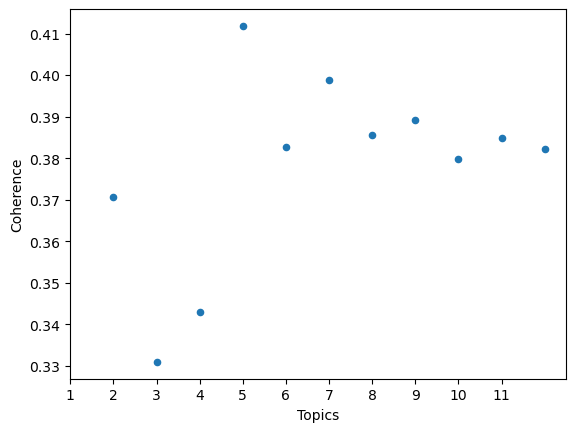

In [21]:
lyrics_lda_tuning.plot(x ='Topics', y='Coherence', kind = 'scatter', xticks=range(1,12))

Based on the above, I decided to have Topic number 5. To have more detailed parameter tuning below.

In [24]:
lyrics_lda_tuning = grid_search_lda(5, 5, 1, lyrics_term_matrix,lyrics_dictionary,lyrics_lemmatized)

LDA will execute 12 iterations
Completed model based on 5 LDA topics. Finished 100.0% of LDA runs
Execution time to calculate for topic 5: 5hour:7min:9sec


In [25]:
### lyrics_lda_tuning.to_csv('lyrics_lda_tuning_5.csv',index=False)

In [6]:
### lyrics_lda_tuning = pd.read_csv('lyrics_lda_tuning_5.csv')

In [8]:
def lda_model(doc_term_matrix, dictionary, tuned_topics, tuned_alpha, tuned_beta, data_lemmatized):
    tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                           id2word=dictionary,
                           num_topics=tuned_topics,
                           random_state=100,
                           passes=10,
                           alpha=tuned_alpha,
                           eta=tuned_beta,
                           workers = workers)
    return tuned_lda_model

In [15]:
lyrics_lda_tuning

,Topics,Alpha,Beta,Coherence
0,5,0.1,0.1,0.401179
1,5,0.1,1,0.354662
2,5,0.1,symmetric,0.348858
3,5,1,0.1,0.371974
4,5,1,1,0.350176
5,5,1,symmetric,0.360095
6,5,symmetric,0.1,0.349488
7,5,symmetric,1,0.340906
8,5,symmetric,symmetric,0.371974
9,5,asymmetric,0.1,0.371877


In [25]:
lyrics_topics, lyrics_alpha, lyrics_beta = best_lda_topics(lyrics_lda_tuning, 5)

Best Parameters: Topics: 5, Alpha: asymmetric, Beta: symmetric


In [ ]:
lyrics_lda_model_1 = lda_model(lyrics_term_matrix, lyrics_dictionary, lyrics_topics, lyrics_alpha, lyrics_beta , lyrics_lemmatized)

In [29]:
### lyrics_lda_model_1.save('lyrics_lda_model_1')

In [19]:
lyrics_lda_model_1 =  models.ldamodel.LdaModel.load('lyrics_lda_model_1')

In [30]:
%%time
time_now()
lda_display_1 = gensimvis.prepare(lyrics_lda_model_1, lyrics_term_matrix, lyrics_dictionary, sort_topics=False, mds='mmds')

2023/03/01 13:07
CPU times: total: 3min 38s
Wall time: 4min 11s


In [31]:
pyLDAvis.display(lda_display_1)

## Topic clustering by using the probability of the each topic.

In [4]:
def find_max(topics_doc):
    list_A = []
    list_B = []
    for q in topics_doc:
        list_A.append(q[0])
        list_B.append(q[1])
    max_probability  = max(list_B)
    max_idx = list_B.index(max_probability)
    max_category = list_A[max_idx]
    return max_category,max_probability

In [20]:
%%time
time_now()
topic_lst = []
prob_lst = []
for i, topics_doc in enumerate(lyrics_lda_model_1[lyrics_term_matrix]):
    max_category,max_probability = find_max(topics_doc)
    topic_lst.append(max_category)
    prob_lst.append(max_probability)

2023/03/01 13:43
CPU times: total: 49.5 s
Wall time: 50.3 s


In [10]:
len(df_lyrics)

15711

In [11]:
length_lyrics = len(df_lyrics)

In [12]:
len(topic_lst[0:length_lyrics])

15711

In [13]:
len(topic_lst[length_lyrics:length_lyrics*2])

15711

In [14]:
len(topic_lst[length_lyrics*2:length_lyrics*3])

15711

Take the higher probability cluster between unigram & bigram & Trigram.

In [ ]:
topic_cluster = pd.DataFrame({
    'unigram_clus': topic_lst[0:length_lyrics], 
    'unigram_prob': prob_lst[0:length_lyrics], 
    'bigram_clus': topic_lst[length_lyrics:length_lyrics*2],
    'bigram_prob': prob_lst[length_lyrics:length_lyrics*2],
    'trigram_clus': topic_lst[length_lyrics*2:length_lyrics*3],
    'trigram_prob': prob_lst[length_lyrics*2:length_lyrics*3]})

In [ ]:
topic_cluster['cluster'] = topic_cluster\
.apply(lambda x: x['unigram_clus'] if (x['unigram_prob'] >= x['bigram_prob'])&(x['unigram_prob']>=x['trigram_prob'])\
       else x['bigram_clus'] if (x['bigram_prob'] >= x['unigram_prob'])&(x['bigram_prob']>=x['trigram_prob'])\
       else x['trigram_clus'] if (x['trigram_prob'] >= x['unigram_prob'])&(x['trigram_prob']>=x['bigram_prob'])\
      else 'NaN', axis=1)

In [45]:
topic_cluster['UID'] =  df_lyrics['UID']

In [51]:
topic_cluster['cluster'].value_counts()

0.0    13330
2.0     1143
3.0      604
4.0      444
1.0      190
Name: cluster, dtype: int64

In [22]:
prob_dict = {'cluster_0':[],
            'cluster_1':[],
            'cluster_2':[],
            'cluster_3':[],
            'cluster_4':[]
            }

In [23]:
for i, topics_doc in enumerate(lyrics_lda_model_1[lyrics_term_matrix]):
    for k in range(len(prob_dict)):
        for j in range(len(topics_doc)):
            if k == topics_doc[j][0]:
                prob_dict['cluster_'+str(k)].append(topics_doc[j][1])
        try:
            prob_dict['cluster_'+str(k)][i]
        except:
            prob_dict['cluster_'+str(k)].append(0)

In [24]:
df_cluster_prob = pd.DataFrame(prob_dict)

In [26]:
df_cluster_prob = df_cluster_prob.loc[:len(df_lyrics)]

In [27]:
df_cluster_prob

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
0,0.991888,0.0,0.0,0.00000,0.000000
1,0.999050,0.0,0.0,0.00000,0.000000
2,0.990210,0.0,0.0,0.00000,0.000000
3,0.177518,0.0,0.0,0.00000,0.822472
4,0.992819,0.0,0.0,0.00000,0.000000
...,...,...,...,...,...
15707,0.995353,0.0,0.0,0.00000,0.000000
15708,0.879121,0.0,0.0,0.10596,0.000000
15709,0.996153,0.0,0.0,0.00000,0.000000
15710,0.999606,0.0,0.0,0.00000,0.000000


In [29]:
df_cluster_prob['UID'] = df_lyrics['UID']

In [30]:
df_cluster_prob.to_csv('df_cluster_prob.csv', index=False)

In [298]:
df_cluster_prob = pd.read_csv('df_cluster_prob.csv')

In [318]:
df_merge_final = pd.merge(df_merge, df_cluster_prob, on='UID', how='left')

In [319]:
df_merge_final.to_csv('df_merge_final.csv', index=False)

In [321]:
df_features_final = pd.merge(df_features, df_cluster_prob, on='UID', how='left')

In [322]:
df_features_final.to_csv('df_features_final.csv', index=False)

In [2]:
df_merge_final = pd.read_csv('df_merge_final.csv')
df_features_final = pd.read_csv('df_features_final.csv')

# Modeling

Separate users into train and test (Content-based does not require this, but for comparison with Light FM, use the same data set.)
Use 20% of users as a test data set and keep 80% of users as a train data set.

In [3]:
all_users = df_merge_final['user_id'].unique()

In [4]:
int(len(all_users)*2 / 10)

2443

In [5]:
test_users = all_users[:int(len(all_users)*2 / 10)]

In [6]:
train_users = all_users[int(len(all_users)*2 / 10):]

In [7]:
df_train = df_merge_final[df_merge_final['user_id'].isin(train_users)]
df_test = df_merge_final[df_merge_final['user_id'].isin(test_users)]

In [17]:
clusters = ['cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4']
acoustic_features = ['danceability', 'loudness_energy', 'key', 
'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo']

## Contents based recommendation

### Acoustic features only

In [220]:
df_features_final.columns

Index(['track_id', 'Search_name', 'artists', 'danceability', 'key', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'popularity', 'UID', 'user_numbers',
       'cluster', 'loudness_energy', 'cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4'],
      dtype='object')

In [221]:
def cos_similarity_matrix (vectors):
    unit_vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
    return np.matmul(unit_vectors, unit_vectors.T)

Calculate cosine similarity

In [222]:
matrix = cos_similarity_matrix(df_features_final[acoustic_features].values)
df_cossim = pd.DataFrame(matrix, 
                  index=df_features_final['UID'].tolist(), 
                  columns=df_features_final['UID'].tolist())

In [223]:
# df_cossim = df_cossim.drop(np.nan, axis=0)

In [224]:
# df_cossim = df_cossim.drop(np.nan, axis=1)

Calculate the similarity score based on the users' listening history.  
Formula: [# of times he/she Listened] * [similarity score]

In [225]:
df_user_times = df_test.groupby(['user_id','UID']).count()['track_id'].unstack().fillna(0).reset_index()

In [226]:
listened_list = list(df_user_times.drop('user_id', axis=1).columns)

Make the diagonal 0 because if the user listened to the song, it should not be included in the score.

In [227]:
df_cossim = df_cossim[listened_list]

In [228]:
df_cossim = df_cossim.T[listened_list]

In [229]:
array_cossim = df_cossim.values

In [230]:
array_cossim_diag =  np.diag(array_cossim)

In [231]:
array_cossim_diag.flags.writeable = True

In [232]:
for i in range(len(array_cossim_diag)):
    array_cossim_diag[i] = 0

In [233]:
array_cossim

array([[ 0.        ,  0.21627737,  0.10351605, ...,  0.34876573,
         0.34115445,  0.1473931 ],
       [ 0.21627737,  0.        , -0.05210414, ..., -0.19340302,
        -0.15666685,  0.21780025],
       [ 0.10351605, -0.05210414,  0.        , ..., -0.03387294,
        -0.30962753, -0.78378392],
       ...,
       [ 0.34876573, -0.19340302, -0.03387294, ...,  0.        ,
         0.44532612,  0.40910331],
       [ 0.34115445, -0.15666685, -0.30962753, ...,  0.44532612,
         0.        ,  0.41706616],
       [ 0.1473931 ,  0.21780025, -0.78378392, ...,  0.40910331,
         0.41706616,  0.        ]])

Create each user's listening songs history table. Row: Users, Columns: Songs, Values: # of times listened to a song.

In [234]:
len(df_user_times.columns)

7103

In [235]:
len(df_cossim.columns)

7102

In [236]:
array_user_times = df_user_times[df_cossim.columns].values

In [237]:
array_user_times

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [238]:
user_sim_matrix =  np.matmul(array_user_times, array_cossim.T)

In [239]:
df_user_sim = pd.DataFrame(user_sim_matrix,
                          columns=df_cossim.columns,
                           index=df_user_times['user_id'])

In [240]:
df_user_sim

,#1 In Heaven - Infuze Remix_MNDR,#1 In Heaven_MNDR,#2 In The Model Home Series_Guided By Voices,#21_Aphex Twin,#BOOM - Radio Edit_Heatbeat,#YawaDey_Burna Boy,'Til I See You - Live_Hillsong United,'Til We Meet Again_Elizabeth Cotten,'Tis Autumn_Stacey Kent,'tain't What You Do_Swing Republic,...,hostage_Dangerkids,iROK - Radio Edit_Tom Fall,iT_Christine and the Queens,likethesun_Musiq Soulchild,losing my edge - live at madison square garden_LCD Soundsystem,love fail: the wood and the vine_David Lang,nico_The Cult,no changes_Vanilla,‘95 aka Make Things Right_Lemon Jelly,…To Ashes_Chelsea Grin
user_id,,,,,,,,,,,,,,,,,,,,,
00123e0f544dee3ab006aa7f1e5725a7,-23.125465,-1.536854,9.954823,24.001963,-12.361250,-2.291349,13.375961,0.568346,35.480870,-20.455652,...,-22.648202,-30.909452,-0.787658,-14.258019,-11.247853,28.282381,-8.611297,-15.816664,-19.447626,-13.924594
001c4e5b73eca68ee9756bb0c7d2f855,3.503518,3.033693,0.118902,-3.767419,0.044038,1.906769,1.524892,0.759877,-2.626167,0.160974,...,3.278068,0.009420,2.200858,2.149152,-1.615103,-2.748988,3.258621,-0.093716,-0.091027,1.124301
002544ea04896444d79d3e4a7e073422,0.532185,0.275299,-0.108070,-1.368578,-0.409108,0.478921,-0.377054,0.753802,-0.916843,1.020701,...,1.025960,0.766924,0.623134,0.277490,0.498173,-1.176934,-0.175504,-0.305697,0.626198,0.006211
0059ac6b3ba3c3f415f09059a3bd703a,0.123464,0.347880,-0.070815,0.745485,0.178920,-0.496865,0.808400,-1.072715,0.545547,-0.820149,...,-0.271650,-0.088082,-1.000460,0.215593,-0.804392,1.215153,1.037290,-0.390279,-1.139683,-0.206530
0098b965803a4c10723f8e216f9e0904,1.084524,1.842030,-1.880613,-1.475915,0.179531,-0.533592,1.849542,0.072597,-1.253711,-0.659379,...,2.347684,0.720235,0.790315,1.558644,0.036961,-1.239100,1.122898,-0.716950,0.468610,1.405088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff02074397d6385f122f36cc11372fc6,3.790146,3.176950,1.838081,-6.135064,1.066679,4.728038,-1.118727,2.789473,-4.443796,2.114937,...,3.728660,1.469542,3.477777,0.646776,2.107558,-6.642869,0.938689,2.013358,2.974561,0.609358
ff0c5d4b80f060694a8a3180485c56b1,-0.086556,0.270073,-0.805738,0.163485,0.106819,-0.915204,0.427310,-0.439413,-0.067613,-0.865075,...,0.650175,0.333012,-0.636325,0.111194,0.622694,0.275247,0.033612,-0.463075,0.230541,0.135934
ff7b01325c3a61f91c9a6e99d77fd0fe,1.127476,0.974147,0.907775,-0.712932,0.175598,1.198699,0.404108,-0.585236,-0.466933,-0.625886,...,0.423272,-0.184409,-0.368615,0.232375,-0.393437,-0.228329,1.510846,0.064241,-0.691561,-0.622333


In [241]:
### df_user_sim.to_csv('df_user_sim.csv')

In [242]:
len(df_user_sim.reset_index()['user_id'].unique())

2443

#### Evaluation
To see the Precision across the full range of recall values, to calculate Average Precision.  
AP = 1 / |Relevant| * ∑i=1 k relevant(i) * Precision@i  
Where
relevant(i) = 1 if the recommendation item at rank i is correct and 0 if not.
Relevant is the set of relevant/correct recommendations from the universe of items.

In [243]:
df_user_times['total'] = df_user_times.sum(axis=1)

Sort out users who listened to songs more than once. (Because we cannot know the result if the customer only listened to one song.)

In [244]:
len(df_user_times[df_user_times['total']>1])

2091

In [245]:
df_user_listen = df_user_times[df_user_times['total']>1]

In [246]:
df_user_listen = df_user_listen.drop('total', axis=1)

In [247]:
df_user_listen

UID,user_id,#1 In Heaven - Infuze Remix_MNDR,#1 In Heaven_MNDR,#2 In The Model Home Series_Guided By Voices,#21_Aphex Twin,#BOOM - Radio Edit_Heatbeat,#YawaDey_Burna Boy,'Til I See You - Live_Hillsong United,'Til We Meet Again_Elizabeth Cotten,'Tis Autumn_Stacey Kent,...,hostage_Dangerkids,iROK - Radio Edit_Tom Fall,iT_Christine and the Queens,likethesun_Musiq Soulchild,losing my edge - live at madison square garden_LCD Soundsystem,love fail: the wood and the vine_David Lang,nico_The Cult,no changes_Vanilla,‘95 aka Make Things Right_Lemon Jelly,…To Ashes_Chelsea Grin
0,00123e0f544dee3ab006aa7f1e5725a7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,001c4e5b73eca68ee9756bb0c7d2f855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,002544ea04896444d79d3e4a7e073422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0059ac6b3ba3c3f415f09059a3bd703a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0098b965803a4c10723f8e216f9e0904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2438,ff02074397d6385f122f36cc11372fc6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2439,ff0c5d4b80f060694a8a3180485c56b1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2440,ff7b01325c3a61f91c9a6e99d77fd0fe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2441,ff88b6f7eeb1bc38bda277737be4223a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [248]:
df_user_listen = df_user_listen.set_index('user_id')

In [249]:
df_user_listen['AP'] = ''
for ID in df_user_listen.index:
    # Sort by recommended order
    recommended = pd.DataFrame(df_user_sim.loc[ID]).sort_values(by=ID, ascending=False)
    # Add if the song was listened or not, and create data frame. 
    listened = pd.DataFrame(df_user_listen.loc[ID])

    evaluation = pd.concat([recommended, listened], axis=1)
    evaluation.columns = ['recommended','listened']

    # Before getting the index(Numer of recommendation when it gets relevant track), 
    # create a list when the track was listened. 
    listened_lst = list(evaluation['listened'] != 0)
    
    # To calculate precision @i , number of relevant track was calculated. 
    accumulate_lst = list(itertools.accumulate(listened_lst))
    
    # To get the index by using listened_lst.
    index_lst = [i for i, x in enumerate(listened_lst) if x == True]

    # calculate Average precision, and store in the user's AP value.
    sum_p_at_i = 0
    for i, x in enumerate(index_lst):
        sum_p_at_i += accumulate_lst[index_lst[i]] / (x + 1)
    df_user_listen['AP'][ID] = sum_p_at_i / len(index_lst)

In [250]:
df_user_listen = df_user_listen.reset_index()
df_user_times = df_user_times.reset_index()

In [251]:
df_user_listen = pd.merge(df_user_listen, df_user_times[['user_id', 'total']], on='user_id', how='left')

To see the mean of Average Precision when the user listened to more than one song, ten songs, 100 songs, or 1000 songs.

In [252]:
method = []
MAP_1 = []
MAP_10 = []
MAP_100 = []
MAP_1000 = []

#### Mean of Average precision

In [253]:
method.append('Contentsbase_Acoustic')

##### 1 song

In [254]:
MAP_1.append(df_user_listen['AP'].mean())
df_user_listen['AP'].mean()

0.0028476410287195664

##### 10 songs

In [255]:
MAP_10.append(df_user_listen[df_user_listen['total'] > 10]['AP'].mean())
df_user_listen[df_user_listen['total'] > 10]['AP'].mean()

0.005837135144425454

##### 100 songs

In [256]:
MAP_100.append(df_user_listen[df_user_listen['total'] > 100]['AP'].mean())
df_user_listen[df_user_listen['total'] > 100]['AP'].mean()

0.030935371423521846

##### 1000 songs

In [257]:
MAP_1000.append(df_user_listen[df_user_listen['total'] > 1000]['AP'].mean())
df_user_listen[df_user_listen['total'] > 1000]['AP'].mean()

0.08985115719303748

### Acoustic features + Semantic features

Calculate cosine similarity

In [258]:
matrix = cos_similarity_matrix(df_features_final[acoustic_features + clusters].values)
df_cossim = pd.DataFrame(matrix, 
                  index=df_features_final['UID'].tolist(), 
                  columns=df_features_final['UID'].tolist())

In [259]:
# df_cossim = df_cossim.drop(np.nan, axis=0)

In [260]:
# df_cossim = df_cossim.drop(np.nan, axis=1)

Calculate the similarity score based on the users' listening history.  
Formula: [# of times he/she Listened] * [similarity score]

In [261]:
df_user_times = df_test.groupby(['user_id','UID']).count()['track_id'].unstack().fillna(0).reset_index()

In [262]:
listened_list = list(df_user_times.drop('user_id', axis=1).columns)

Make the diagonal 0 because if the user listened to the song, it should not be included in the score.

In [263]:
df_cossim = df_cossim[listened_list]

In [264]:
df_cossim = df_cossim.T[listened_list]

In [265]:
array_cossim = df_cossim.values

In [266]:
array_cossim_diag =  np.diag(array_cossim)

In [267]:
array_cossim_diag.flags.writeable = True

In [268]:
for i in range(len(array_cossim_diag)):
    array_cossim_diag[i] = 0

In [269]:
array_cossim

array([[ 0.        ,  0.18668212,  0.08380367, ...,  0.30490244,
         0.29440345,  0.13324126],
       [ 0.18668212,  0.        ,  0.10451181, ..., -0.0808384 ,
        -0.03400242,  0.23976328],
       [ 0.08380367,  0.10451181,  0.        , ...,  0.10835828,
        -0.10410555, -0.63183219],
       ...,
       [ 0.30490244, -0.0808384 ,  0.10835828, ...,  0.        ,
         0.49912462,  0.4203208 ],
       [ 0.29440345, -0.03400242, -0.10410555, ...,  0.49912462,
         0.        ,  0.42707327],
       [ 0.13324126,  0.23976328, -0.63183219, ...,  0.4203208 ,
         0.42707327,  0.        ]])

Create each user's listening songs history table. Row: Users, Columns: Songs, Values: # of times listened to a song.

In [270]:
len(df_user_times.columns)

7103

In [271]:
len(df_cossim.columns)

7102

In [272]:
array_user_times = df_user_times[df_cossim.columns].values

In [273]:
array_user_times

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [274]:
user_sim_matrix =  np.matmul(array_user_times, array_cossim.T)

In [275]:
df_user_sim = pd.DataFrame(user_sim_matrix,
                          columns=df_cossim.columns,
                           index=df_user_times['user_id'])

In [276]:
df_user_sim

,#1 In Heaven - Infuze Remix_MNDR,#1 In Heaven_MNDR,#2 In The Model Home Series_Guided By Voices,#21_Aphex Twin,#BOOM - Radio Edit_Heatbeat,#YawaDey_Burna Boy,'Til I See You - Live_Hillsong United,'Til We Meet Again_Elizabeth Cotten,'Tis Autumn_Stacey Kent,'tain't What You Do_Swing Republic,...,hostage_Dangerkids,iROK - Radio Edit_Tom Fall,iT_Christine and the Queens,likethesun_Musiq Soulchild,losing my edge - live at madison square garden_LCD Soundsystem,love fail: the wood and the vine_David Lang,nico_The Cult,no changes_Vanilla,‘95 aka Make Things Right_Lemon Jelly,…To Ashes_Chelsea Grin
user_id,,,,,,,,,,,,,,,,,,,,,
00123e0f544dee3ab006aa7f1e5725a7,-19.141461,11.495757,27.571435,30.681229,3.056836,13.622132,29.927034,17.817192,43.938517,-11.635795,...,-0.888972,-15.074227,13.602767,-0.024680,1.754956,27.737945,8.917691,-1.773346,-3.131816,-7.852829
001c4e5b73eca68ee9756bb0c7d2f855,2.890492,3.612881,1.642143,-2.780316,1.126192,2.887448,2.704666,2.017906,-1.457199,0.717354,...,4.157821,1.016097,3.041054,2.906526,-0.463403,-2.457006,4.034022,0.914643,1.073898,1.402094
002544ea04896444d79d3e4a7e073422,0.458872,0.497200,0.314325,-1.137071,-0.115770,0.765255,0.012625,1.002237,-0.616184,1.112205,...,1.213306,0.934361,0.831947,0.467992,0.694763,-1.086334,0.151780,-0.045707,0.821779,0.063662
0059ac6b3ba3c3f415f09059a3bd703a,0.136341,0.506892,0.220093,0.802274,0.367752,-0.196757,0.965742,-0.682520,0.649569,-0.664558,...,0.051781,0.110673,-0.681740,0.397082,-0.561918,1.138277,1.156432,-0.168163,-0.810351,-0.115845
0098b965803a4c10723f8e216f9e0904,0.948652,2.396488,-0.440855,-0.926186,0.955927,0.468064,2.643597,1.021937,-0.504590,-0.216143,...,3.024353,1.361530,1.507086,2.150941,0.658320,-1.101566,1.970376,0.060733,1.177648,1.579234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff02074397d6385f122f36cc11372fc6,3.274364,4.910316,4.674481,-4.381649,3.216081,6.716229,2.045100,5.238175,-2.218514,3.156535,...,6.141046,3.401671,5.409454,2.623971,3.856733,-6.010899,3.478508,3.839326,4.925645,1.372608
ff0c5d4b80f060694a8a3180485c56b1,-0.109501,0.594643,-0.081385,0.419950,0.502353,-0.341976,0.893194,0.138292,0.319428,-0.588993,...,1.027053,0.642931,-0.139216,0.441038,0.917675,0.309779,0.462451,-0.049033,0.620673,0.256255
ff7b01325c3a61f91c9a6e99d77fd0fe,0.947279,1.273345,1.304389,-0.454499,0.523123,1.506241,0.859607,0.054692,-0.084342,-0.356271,...,0.896323,0.164491,0.142161,0.543125,-0.018765,-0.209015,1.727280,0.386998,-0.207590,-0.429191


In [277]:
### df_user_sim.to_csv('df_user_sim.csv')

In [278]:
len(df_user_sim.reset_index()['user_id'].unique())

2443

### Evaluation
To see the Precision across the full range of recall values, to calculate Average Precision.  
AP = 1 / |Relevant| * ∑i=1 k relevant(i) * Precision@i  
Where  
relevant(i) = 1 if the recommendation item at rank i is correct and 0 if not.
Relevant is the set of relevant/correct recommendations from the universe of items.

In [279]:
df_user_times['total'] = df_user_times.sum(axis=1)

Sort out users who listened to more than 1 song. (Because we cannot know the result if the customer only listened to one song.)

In [280]:
len(df_user_times[df_user_times['total']>1])

2091

In [281]:
df_user_listen = df_user_times[df_user_times['total']>1]

In [282]:
df_user_listen = df_user_listen.drop('total', axis=1)

In [283]:
df_user_listen

UID,user_id,#1 In Heaven - Infuze Remix_MNDR,#1 In Heaven_MNDR,#2 In The Model Home Series_Guided By Voices,#21_Aphex Twin,#BOOM - Radio Edit_Heatbeat,#YawaDey_Burna Boy,'Til I See You - Live_Hillsong United,'Til We Meet Again_Elizabeth Cotten,'Tis Autumn_Stacey Kent,...,hostage_Dangerkids,iROK - Radio Edit_Tom Fall,iT_Christine and the Queens,likethesun_Musiq Soulchild,losing my edge - live at madison square garden_LCD Soundsystem,love fail: the wood and the vine_David Lang,nico_The Cult,no changes_Vanilla,‘95 aka Make Things Right_Lemon Jelly,…To Ashes_Chelsea Grin
0,00123e0f544dee3ab006aa7f1e5725a7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,001c4e5b73eca68ee9756bb0c7d2f855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,002544ea04896444d79d3e4a7e073422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0059ac6b3ba3c3f415f09059a3bd703a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0098b965803a4c10723f8e216f9e0904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2438,ff02074397d6385f122f36cc11372fc6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2439,ff0c5d4b80f060694a8a3180485c56b1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2440,ff7b01325c3a61f91c9a6e99d77fd0fe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2441,ff88b6f7eeb1bc38bda277737be4223a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [284]:
df_user_listen = df_user_listen.set_index('user_id')

In [285]:
df_user_listen['AP'] = ''
for ID in df_user_listen.index:
    # Sort by recommended order
    recommended = pd.DataFrame(df_user_sim.loc[ID]).sort_values(by=ID, ascending=False)
    # Add if the song was listened or not, and create data frame. 
    listened = pd.DataFrame(df_user_listen.loc[ID])

    evaluation = pd.concat([recommended, listened], axis=1)
    evaluation.columns = ['recommended','listened']

    # Before getting the index(Numer of recommendation when it gets relevant track), 
    # create a list when the track was listened. 
    listened_lst = list(evaluation['listened'] != 0)
    
    # To calculate precision @i , number of relevant track was calculated. 
    accumulate_lst = list(itertools.accumulate(listened_lst))
    
    # To get the index by using listened_lst.
    index_lst = [i for i, x in enumerate(listened_lst) if x == True]

    # calculate Average precision, and store in the user's AP value.
    sum_p_at_i = 0
    for i, x in enumerate(index_lst):
        sum_p_at_i += accumulate_lst[index_lst[i]] / (x + 1)
    df_user_listen['AP'][ID] = sum_p_at_i / len(index_lst)

In [286]:
df_user_listen = df_user_listen.reset_index()
df_user_times = df_user_times.reset_index()

In [287]:
df_user_listen = pd.merge(df_user_listen, df_user_times[['user_id', 'total']], on='user_id', how='left')

To see the mean of Average Precision when the user listened to more than one song, ten songs, 100 songs, or 1000 songs.

#### Mean of Average precision

In [288]:
method.append('Contentsbase_Acoustic_Semantic')

##### 1 song

In [289]:
MAP_1.append(df_user_listen['AP'].mean())
df_user_listen['AP'].mean()

0.002745727667863466

##### 10 songs

In [290]:
MAP_10.append(df_user_listen[df_user_listen['total'] > 10]['AP'].mean())
df_user_listen[df_user_listen['total'] > 10]['AP'].mean()

0.005702861398945418

##### 100 songs

In [291]:
MAP_100.append(df_user_listen[df_user_listen['total'] > 100]['AP'].mean())
df_user_listen[df_user_listen['total'] > 100]['AP'].mean()

0.030792384570643

##### 1000 songs

In [292]:
MAP_1000.append(df_user_listen[df_user_listen['total'] > 1000]['AP'].mean())
df_user_listen[df_user_listen['total'] > 1000]['AP'].mean()

0.08762031111020765

## Light FM

### Acoustic features only

#### Prepare item features

In [61]:
df_interact = df_train.copy()

In [62]:
df_interact['item_features'] = df_interact.apply(lambda x: {'danceability':x['danceability'],
                                                  'key':x['key'],
                                                  'loudness_energy':x['loudness_energy'],
                                                  'speechiness':x['speechiness'],
                                                  'acousticness':x['acousticness'],
                                                  'instrumentalness':x['instrumentalness'],
                                                  'liveness':x['liveness'],
                                                  'valence':x['valence'],
                                                  'tempo':x['tempo']}, axis=1)

In [63]:
df_interact = df_interact[['user_id', 'UID', 'item_features']]

In [64]:
df_interact.head(5)

,user_id,UID,item_features
29205,769f1f95229e2667222ab32accc64199,Carry You Home_James Blunt,"{'danceability': 0.582, 'key': 2.0, 'loudness_..."
29206,769f1f95229e2667222ab32accc64199,Circle Of Life_Elton John,"{'danceability': 0.276, 'key': 10.0, 'loudness..."
29207,769f1f95229e2667222ab32accc64199,Ooh La La_Goldfrapp,"{'danceability': 0.821, 'key': 6.0, 'loudness_..."
29208,769f1f95229e2667222ab32accc64199,Supreme_Robbie Williams,"{'danceability': 0.562, 'key': 5.0, 'loudness_..."
29209,769f1f95229e2667222ab32accc64199,The Road To Mandalay_Robbie Williams,"{'danceability': 0.624, 'key': 5.0, 'loudness_..."


In [65]:
df_interact['item_features'] = df_interact.apply(lambda x: (x['UID'], x['item_features']), axis=1)

#### Prepare unique features

In [66]:
df_item = df_features_final[['UID']+acoustic_features]

In [67]:
df_item['item_features'] = df_item.apply(lambda x: {'danceability':x['danceability'],
                                                  'key':x['key'],
                                                  'loudness_energy':x['loudness_energy'],
                                                  'speechiness':x['speechiness'],
                                                  'acousticness':x['acousticness'],
                                                  'instrumentalness':x['instrumentalness'],
                                                  'liveness':x['liveness'],
                                                  'valence':x['valence'],
                                                  'tempo':x['tempo']}, axis=1)

In [68]:
df_item['item_features'] = df_item.apply(lambda x: (x['UID'], x['item_features']), axis=1)

In [69]:
df_interaction = df_interact[["user_id", "UID"]].drop_duplicates().reset_index(drop=True)

### Hyper parameter tuning with 5 cross validation

In [30]:
users = df_interaction['user_id'].unique()

In [31]:
batch_size = int(len(users) / 5)

In [32]:
user_1 = users[:batch_size]
user_2 = users[batch_size:batch_size*2]
user_3 = users[batch_size*2:batch_size*3]
user_4 = users[batch_size*3:batch_size*4]
user_5 = users[batch_size*4:batch_size*5]

In [33]:
user_list = [user_1, user_2, user_3, user_4, user_5]

### RandomSearch
Refered to the code here. linkedin.com/notifications/

In [37]:
def flatten_seq(sequences):
    sequences = [i if type(i) == list else [i] for i in sequences]
    flattened = list(itertools.chain.from_iterable(sequences))
    return flattened

In [23]:
def sample_hyperparameters():

    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }

In [293]:
def random_search_cv(num_samples, num_threads, df_interaction, user_list, feature_list):
    time_now()
    train_precision_list = []
    test_precision_list = []
    train_recall_list = []
    test_recall_list = []
    pram_list = []
    i = 1
    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        test_precision = []
        test_recall = []
        train_precision = []
        train_recall = []
        for j, users in enumerate(user_list):
            df_train_interactions = df_interaction[~df_interaction['user_id'].isin(users)]
            df_test_interactions = df_interaction[df_interaction['user_id'].isin(users)]
            train_interactions = list(df_train_interactions.itertuples(index=False, name=None)) 
            test_interactions = list(df_test_interactions.itertuples(index=False, name=None))
            
            uq_users = np.unique(df_interaction.user_id.values)
            uq_items = np.unique(df_item.UID)

            dataset = Dataset()
            dataset.fit(uq_users, uq_items, item_features=feature_list)

            # Because it iis implicit feedback, no weight interaction
            train_interactions, _ = dataset.build_interactions(train_interactions)
            test_interactions, _ = dataset.build_interactions(test_interactions)

            item_features = dataset.build_item_features(flatten_seq(list(df_item.item_features.values)))

            num_epochs = hyperparams.pop("num_epochs")
            model = LightFM(**hyperparams)
            model.fit(train_interactions, item_features=item_features, epochs=num_epochs, num_threads=num_threads)

            hyperparams["num_epochs"] = num_epochs
            test_precision.append(precision_at_k(model, test_interactions=test_interactions,
                                                        item_features=item_features,
                                                          num_threads=num_threads,
                                                         k=10).mean())
            test_recall.append(recall_at_k(model, test_interactions=test_interactions,
                                                        item_features=item_features,
                                             num_threads=num_threads,
                                                         k=10).mean())
            train_precision.append(precision_at_k(model, test_interactions=train_interactions,
                                                        item_features=item_features,
                                                    num_threads=num_threads,
                                                         k=10).mean())
            train_recall.append(recall_at_k(model, test_interactions=train_interactions,
                                                        item_features=item_features,
                                              num_threads=num_threads,
                                                         k=10).mean())
            print(j)
        train_precision_list.append(np.mean(train_precision))
        test_precision_list.append(np.mean(test_precision))
        train_recall_list.append(np.mean(train_recall))
        test_recall_list.append(np.mean(test_recall))
        pram_list.append(hyperparams)
        print(i)
        time_now()
        i+1
    return train_precision_list, test_precision_list, train_recall_list, test_recall_list, pram_list

In [84]:
train_precision_list, test_precision_list, train_recall_list, test_recall_list, pram_list =\
random_search_cv(num_samples=30, num_threads=7, df_interaction=df_interaction, \
                 user_list=user_list, feature_list=acoustic_features)

2023/03/02 23:14
0
1
2
3
4
1
2023/03/02 23:18
0
1
2
3
4
1
2023/03/02 23:23
0
1
2
3
4
1
2023/03/02 23:27
0
1
2
3
4
1
2023/03/02 23:31
0
1
2
3
4
1
2023/03/02 23:36
0
1
2
3
4
1
2023/03/02 23:40
0
1
2
3
4
1
2023/03/02 23:45
0
1
2
3
4
1
2023/03/02 23:49
0
1
2
3
4
1
2023/03/02 23:53
0
1
2
3
4
1
2023/03/02 23:55
0
1
2
3
4
1
2023/03/03 00:01
0
1
2
3
4
1
2023/03/03 00:05
0
1
2
3
4
1
2023/03/03 00:09
0
1
2
3
4
1
2023/03/03 00:15
0
1
2
3
4
1
2023/03/03 00:19
0
1
2
3
4
1
2023/03/03 00:23
0
1
2
3
4
1
2023/03/03 00:28
0
1
2
3
4
1
2023/03/03 00:32
0
1
2
3
4
1
2023/03/03 00:38
0
1
2
3
4
1
2023/03/03 00:42
0
1
2
3
4
1
2023/03/03 00:47
0
1
2
3
4
1
2023/03/03 00:51
0
1
2
3
4
1
2023/03/03 00:57
0
1
2
3
4
1
2023/03/03 01:01
0
1
2
3
4
1
2023/03/03 01:07
0
1
2
3
4
1
2023/03/03 01:12
0
1
2
3
4
1
2023/03/03 01:16
0
1
2
3
4
1
2023/03/03 01:20
0
1
2
3
4
1
2023/03/03 01:24
0
1
2
3
4
1
2023/03/03 01:27


In [93]:
rs_lightfm_acc = pd.DataFrame({
    'train_precision': train_precision_list,
    'test_precision': test_precision_list,
    'train_recall':train_recall_list,
    'test_recall':test_recall_list,
    'parameters':pram_list
})

In [96]:
rs_lightfm_acc.sort_values(by='test_precision', ascending=False)

,train_precision,test_precision,train_recall,test_recall,parameters
20,0.070657,0.065312,0.108553,0.093775,"{'no_components': 47, 'learning_schedule': 'ad..."
18,0.087785,0.065261,0.121040,0.094079,"{'no_components': 44, 'learning_schedule': 'ad..."
19,0.083395,0.064759,0.116332,0.092621,"{'no_components': 35, 'learning_schedule': 'ad..."
21,0.083530,0.064698,0.116384,0.093667,"{'no_components': 27, 'learning_schedule': 'ad..."
17,0.086679,0.064657,0.119553,0.092992,"{'no_components': 34, 'learning_schedule': 'ad..."
26,0.081422,0.064606,0.117545,0.092984,"{'no_components': 40, 'learning_schedule': 'ad..."
24,0.091804,0.064545,0.124170,0.092718,"{'no_components': 51, 'learning_schedule': 'ad..."
15,0.066388,0.064176,0.100979,0.093189,"{'no_components': 24, 'learning_schedule': 'ad..."
14,0.075260,0.063541,0.108445,0.089719,"{'no_components': 30, 'learning_schedule': 'ad..."
0,0.077419,0.063122,0.113562,0.090673,"{'no_components': 32, 'learning_schedule': 'ad..."


In [98]:
rs_lightfm_acc.to_csv('rs_lightfm_acc.csv')

Decided to use index 15, which is the most balanced Test & Train Precision & Recall

In [97]:
rs_lightfm_acc['parameters'][15]

{'no_components': 24,
 'learning_schedule': 'adadelta',
 'loss': 'warp-kos',
 'learning_rate': 0.08789873552680326,
 'item_alpha': 1.6252798167533103e-08,
 'user_alpha': 1.5727620677369755e-08,
 'max_sampled': 5,
 'num_epochs': 34}

In [118]:
hyperparam_acc = rs_lightfm_acc['parameters'][15]

### Final test 

In [103]:
df_interact = df_merge_final.copy()

In [104]:
df_interact['item_features'] = df_interact.apply(lambda x: {'danceability':x['danceability'],
                                                  'key':x['key'],
                                                  'loudness_energy':x['loudness_energy'],
                                                  'speechiness':x['speechiness'],
                                                  'acousticness':x['acousticness'],
                                                  'instrumentalness':x['instrumentalness'],
                                                  'liveness':x['liveness'],
                                                  'valence':x['valence'],
                                                  'tempo':x['tempo']}, axis=1)

In [105]:
df_interact = df_interact[['user_id', 'UID', 'item_features']]

In [106]:
df_interact['item_features'] = df_interact.apply(lambda x: (x['UID'], x['item_features']), axis=1)

In [107]:
df_train_interact = df_interact[df_interact['user_id'].isin(list(df_train['user_id'].unique()))]
df_test_interact = df_interact[df_interact['user_id'].isin(list(df_test['user_id'].unique()))]

#### Prepare unique features

In [108]:
df_item = df_features_final[['UID']+acoustic_features]

In [109]:
df_item['item_features'] = df_item.apply(lambda x: {'danceability':x['danceability'],
                                                  'key':x['key'],
                                                  'loudness_energy':x['loudness_energy'],
                                                  'speechiness':x['speechiness'],
                                                  'acousticness':x['acousticness'],
                                                  'instrumentalness':x['instrumentalness'],
                                                  'liveness':x['liveness'],
                                                  'valence':x['valence'],
                                                  'tempo':x['tempo']}, axis=1)

In [110]:
df_item['item_features'] = df_item.apply(lambda x: (x['UID'], x['item_features']), axis=1)

In [113]:
df_train_interactions = df_train_interact[["user_id", "UID"]].drop_duplicates().reset_index(drop=True)
df_test_interactions = df_test_interact[["user_id", "UID"]].drop_duplicates().reset_index(drop=True)

In [114]:
train_interactions = list(df_train_interactions.itertuples(index=False, name=None)) 
test_interactions = list(df_test_interactions.itertuples(index=False, name=None))

In [115]:
uq_users = np.unique(df_interact.user_id.values)
uq_items = np.unique(df_item.UID)

In [116]:
dataset = Dataset()
dataset.fit(uq_users, uq_items, item_features=acoustic_features)

In [117]:
# Because it iis implicit feedback, no weight interaction
train_interactions, _ = dataset.build_interactions(train_interactions)
test_interactions, _ = dataset.build_interactions(test_interactions)

In [120]:
num_epochs = hyperparam_acc.pop('num_epochs')

In [122]:
item_features = dataset.build_item_features(flatten_seq(list(df_item.item_features.values)))

model = LightFM(**hyperparam_acc)
model.fit(train_interactions, item_features=item_features, epochs=num_epochs)

In [123]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()

In [124]:
def predict_byuser(user_id):
    user_idx = user_id_map[user_id]
    predict = model.predict(user_ids=user_idx, item_ids=np.array(range(0, len(item_id_map))))
    df_predict= pd.DataFrame.from_dict(item_id_map, orient='index').rename(columns={0: "index"}).sort_values(by="index")
    df_predict["Recommendation_score"] = predict
    df_predict = df_predict.sort_values(by="Recommendation_score", ascending=False)
    return df_predict[["Recommendation_score"]]

In [125]:
df_user_times = df_test.groupby(['user_id','UID']).count()['track_id'].unstack().fillna(0).reset_index()

#### Drop only one time listener (Follow same condition as contents based)

In [126]:
df_user_times = df_user_times.set_index('user_id')

In [127]:
df_user_times['total'] = df_user_times.sum(axis=1)

In [128]:
df_user_listen = df_user_times[df_user_times['total']>1]

In [129]:
df_user_listen_T = df_user_listen.drop('total', axis=1).T

In [138]:
userid_list = []
ap_list = []
non_list = []

for ID in df_user_listen.index:
# try:
    evaluation = pd.concat([predict_byuser(ID), df_user_listen_T[ID]],axis=1).fillna(0)
    evaluation.columns = ['recommended','listened']
    # Before getting the index(Numer of recommendation when it gets relevant track), 
    # create a list when the track was listened. 
    listened_lst = list(evaluation['listened'] != 0)

    # To calculate precision @i , number of relevant track was calculated. 
    accumulate_lst = list(itertools.accumulate(listened_lst))

    # To get the index by using listened_lst.
    index_lst = [i for i, x in enumerate(listened_lst) if x == True]

    # calculate Average precision, and store in the user's AP value.
    sum_p_at_i = 0
    for i, x in enumerate(index_lst):
        sum_p_at_i += accumulate_lst[index_lst[i]] / (x + 1)

    userid_list.append(ID)
    ap_list.append(sum_p_at_i / len(index_lst))
# except:
    non_list.append(ID)

In [139]:
df_lightfm_acc_AP = pd.DataFrame({
    "user_id":userid_list,
    'AP':ap_list
})

In [140]:
df_lightfm_acc_AP = pd.merge(df_lightfm_acc_AP, df_user_listen.reset_index()[['user_id', 'total']],\
         on='user_id', how='left')

### Mean of Average precision

In [294]:
method.append('LightFM_Acoustic')

##### 1 song

In [295]:
MAP_1.append(df_lightfm_acc_AP['AP'].mean())
df_lightfm_acc_AP['AP'].mean()

0.03988986686091576

##### 10 songs

In [296]:
MAP_10.append(df_lightfm_acc_AP[df_lightfm_acc_AP['total'] > 10]['AP'].mean())
df_lightfm_acc_AP[df_lightfm_acc_AP['total'] > 10]['AP'].mean()

0.04911141405736044

##### 100 songs

In [297]:
MAP_100.append(df_lightfm_acc_AP[df_lightfm_acc_AP['total'] > 100]['AP'].mean())
df_lightfm_acc_AP[df_lightfm_acc_AP['total'] > 100]['AP'].mean()

0.08082608138933624

##### 1000 songs

In [298]:
MAP_1000.append(df_lightfm_acc_AP[df_lightfm_acc_AP['total'] > 1000]['AP'].mean())
df_lightfm_acc_AP[df_lightfm_acc_AP['total'] > 1000]['AP'].mean()

0.11971714970812383

### Acoustic features + Semantic features

### Prepare item features

In [299]:
df_interact = df_train.copy()

In [300]:
df_interact['item_features'] = df_interact.apply(lambda x: {'danceability':x['danceability'],
                                                  'key':x['key'],
                                                  'loudness_energy':x['loudness_energy'],
                                                  'speechiness':x['speechiness'],
                                                  'acousticness':x['acousticness'],
                                                  'instrumentalness':x['instrumentalness'],
                                                  'liveness':x['liveness'],
                                                  'valence':x['valence'],
                                                  'tempo':x['tempo'],
                                                 'cluster_0':x['cluster_0'],
                                                 'cluster_1':x['cluster_1'],
                                                 'cluster_2':x['cluster_2'],
                                                 'cluster_3':x['cluster_3'],
                                                 'cluster_4':x['cluster_4']}, axis=1)

In [301]:
df_interact = df_interact[['user_id', 'UID', 'item_features']]

In [302]:
df_interact['item_features'] = df_interact.apply(lambda x: (x['UID'], x['item_features']), axis=1)

### Prepare unique features

In [303]:
df_item = df_features_final[['UID']+ acoustic_features + clusters]

In [304]:
df_item['item_features'] = df_item.apply(lambda x: {'danceability':x['danceability'],
                                                  'key':x['key'],
                                                  'loudness_energy':x['loudness_energy'],
                                                  'speechiness':x['speechiness'],
                                                  'acousticness':x['acousticness'],
                                                  'instrumentalness':x['instrumentalness'],
                                                  'liveness':x['liveness'],
                                                  'valence':x['valence'],
                                                  'tempo':x['tempo'],
                                                 'cluster_0':x['cluster_0'],
                                                 'cluster_1':x['cluster_1'],
                                                 'cluster_2':x['cluster_2'],
                                                 'cluster_3':x['cluster_3'],
                                                 'cluster_4':x['cluster_4']}, axis=1)

In [305]:
df_item['item_features'] = df_item.apply(lambda x: (x['UID'], x['item_features']), axis=1)

### Hyper parameter tuning with 5 cross validation

In [306]:
df_interaction = df_interact[["user_id", "UID"]].drop_duplicates().reset_index(drop=True)

In [307]:
users = df_interaction['user_id'].unique()

In [308]:
batch_size = int(len(users) / 5)

In [309]:
user_1 = users[:batch_size]
user_2 = users[batch_size:batch_size*2]
user_3 = users[batch_size*2:batch_size*3]
user_4 = users[batch_size*3:batch_size*4]
user_5 = users[batch_size*4:batch_size*5]

In [310]:
user_list = [user_1, user_2, user_3, user_4, user_5]

### Parameter Tuning

#### Random Search

In [313]:
train_precision_list_sem, test_precision_list_sem, train_recall_list_sem, test_recall_list_sem, pram_list_sem =\
random_search_cv(num_samples=30, num_threads=7, df_interaction=df_interaction, \
                 user_list=user_list, feature_list=acoustic_features+clusters)

2023/03/03 01:59
0
1
2
3
4
1
2023/03/03 02:05
0
1
2
3
4
1
2023/03/03 02:12
0
1
2
3
4
1
2023/03/03 02:16
0
1
2
3
4
1
2023/03/03 02:22
0
1
2
3
4
1
2023/03/03 02:29
0
1
2
3
4
1
2023/03/03 02:36
0
1
2
3
4
1
2023/03/03 02:42
0
1
2
3
4
1
2023/03/03 02:49
0
1
2
3
4
1
2023/03/03 02:54
0
1
2
3
4
1
2023/03/03 03:03
0
1
2
3
4
1
2023/03/03 03:08
0
1
2
3
4
1
2023/03/03 03:15
0
1
2
3
4
1
2023/03/03 03:19
0
1
2
3
4
1
2023/03/03 03:25
0
1
2
3
4
1
2023/03/03 03:32
0
1
2
3
4
1
2023/03/03 03:38
0
1
2
3
4
1
2023/03/03 03:44
0
1
2
3
4
1
2023/03/03 03:52
0
1
2
3
4
1
2023/03/03 03:58
0
1
2
3
4
1
2023/03/03 04:06
0
1
2
3
4
1
2023/03/03 04:12
0
1
2
3
4
1
2023/03/03 04:18
0
1
2
3
4
1
2023/03/03 04:25
0
1
2
3
4
1
2023/03/03 04:33
0
1
2
3
4
1
2023/03/03 04:40
0
1
2
3
4
1
2023/03/03 04:44
0
1
2
3
4
1
2023/03/03 04:50
0
1
2
3
4
1
2023/03/03 04:54
0
1
2
3
4
1
2023/03/03 05:00
0
1
2
3
4
1
2023/03/03 05:05


In [314]:
rs_lightfm_acc_sem = pd.DataFrame({
    'train_precision': train_precision_list_sem,
    'test_precision': test_precision_list_sem,
    'train_recall':train_recall_list_sem,
    'test_recall':test_recall_list_sem,
    'parameters':pram_list_sem
})

In [316]:
rs_lightfm_acc_sem.sort_values(by='test_precision', ascending=False)

,train_precision,test_precision,train_recall,test_recall,parameters
19,0.089263,0.065793,0.125139,0.094763,"{'no_components': 55, 'learning_schedule': 'ad..."
13,0.085728,0.065046,0.131960,0.094160,"{'no_components': 63, 'learning_schedule': 'ad..."
0,0.068232,0.064770,0.115623,0.092841,"{'no_components': 61, 'learning_schedule': 'ad..."
21,0.070384,0.064678,0.106847,0.092924,"{'no_components': 32, 'learning_schedule': 'ad..."
20,0.081548,0.064667,0.124984,0.093380,"{'no_components': 44, 'learning_schedule': 'ad..."
12,0.074618,0.064667,0.114538,0.093720,"{'no_components': 18, 'learning_schedule': 'ad..."
14,0.070793,0.064442,0.109528,0.092154,"{'no_components': 43, 'learning_schedule': 'ad..."
2,0.067969,0.063920,0.109638,0.091101,"{'no_components': 29, 'learning_schedule': 'ad..."
18,0.101087,0.059458,0.217899,0.086085,"{'no_components': 23, 'learning_schedule': 'ad..."
3,0.104047,0.057247,0.225345,0.082955,"{'no_components': 59, 'learning_schedule': 'ad..."


In [315]:
rs_lightfm_acc_sem.to_csv('rs_lightfm_acc_sem.csv')

Decided to use index 2, which is the most balanced Test & Train Precision & Recall

In [317]:
rs_lightfm_acc_sem['parameters'][2]

{'no_components': 29,
 'learning_schedule': 'adadelta',
 'loss': 'warp-kos',
 'learning_rate': 0.019187721306920546,
 'item_alpha': 2.4956921177143628e-08,
 'user_alpha': 1.987591596412512e-08,
 'max_sampled': 11,
 'num_epochs': 11}

In [318]:
hyperparam_acc_sem = rs_lightfm_acc_sem['parameters'][2]

### Final test 

In [319]:
df_interact = df_merge_final.copy()

In [320]:
df_interact['item_features'] = df_interact.apply(lambda x: {'danceability':x['danceability'],
                                                  'key':x['key'],
                                                  'loudness_energy':x['loudness_energy'],
                                                  'speechiness':x['speechiness'],
                                                  'acousticness':x['acousticness'],
                                                  'instrumentalness':x['instrumentalness'],
                                                  'liveness':x['liveness'],
                                                  'valence':x['valence'],
                                                  'tempo':x['tempo'],
                                                 'cluster_0':x['cluster_0'],
                                                 'cluster_1':x['cluster_1'],
                                                 'cluster_2':x['cluster_2'],
                                                 'cluster_3':x['cluster_3'],
                                                 'cluster_4':x['cluster_4']}, axis=1)

In [321]:
df_interact = df_interact[['user_id', 'UID', 'item_features']]

In [322]:
df_interact['item_features'] = df_interact.apply(lambda x: (x['UID'], x['item_features']), axis=1)

In [323]:
df_train_interact = df_interact[df_interact['user_id'].isin(list(df_train['user_id'].unique()))]
df_test_interact = df_interact[df_interact['user_id'].isin(list(df_test['user_id'].unique()))]

##### Prepare unique features

In [324]:
df_item = df_features_final[['UID']+acoustic_features+clusters]

In [325]:
df_item['item_features'] = df_item.apply(lambda x: {'danceability':x['danceability'],
                                                  'key':x['key'],
                                                  'loudness_energy':x['loudness_energy'],
                                                  'speechiness':x['speechiness'],
                                                  'acousticness':x['acousticness'],
                                                  'instrumentalness':x['instrumentalness'],
                                                  'liveness':x['liveness'],
                                                  'valence':x['valence'],
                                                  'tempo':x['tempo'],
                                                 'cluster_0':x['cluster_0'],
                                                 'cluster_1':x['cluster_1'],
                                                 'cluster_2':x['cluster_2'],
                                                 'cluster_3':x['cluster_3'],
                                                 'cluster_4':x['cluster_4']}, axis=1)

In [326]:
df_item['item_features'] = df_item.apply(lambda x: (x['UID'], x['item_features']), axis=1)

In [327]:
df_train_interaction = df_train_interact[["user_id", "UID"]].drop_duplicates().reset_index(drop=True)
df_test_interaction = df_test_interact[["user_id", "UID"]].drop_duplicates().reset_index(drop=True)

In [328]:
train_interactions = list(df_train_interactions.itertuples(index=False, name=None)) 
test_interactions = list(df_test_interactions.itertuples(index=False, name=None))

In [329]:
uq_users = np.unique(df_interact.user_id.values)
uq_items = np.unique(df_item.UID)
dataset = Dataset()
dataset.fit(uq_users, uq_items, item_features=acoustic_features+clusters)

In [330]:
# Because it iis implicit feedback, no weight interaction
train_interactions, _ = dataset.build_interactions(train_interactions)
test_interactions, _ = dataset.build_interactions(test_interactions)

In [331]:
item_features = dataset.build_item_features(flatten_seq(list(df_item.item_features.values)))

In [333]:
num_epochs = hyperparam_acc_sem.pop('num_epochs')

In [334]:
model = LightFM(**hyperparam_acc_sem)
model.fit(train_interactions, item_features=item_features, epochs=num_epochs)

In [335]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()

In [336]:
def predict_byuser(user_id):
    user_idx = user_id_map[user_id]
    predict = model.predict(user_ids=user_idx, item_ids=np.array(range(0, len(item_id_map))))
    df_predict= pd.DataFrame.from_dict(item_id_map, orient='index').rename(columns={0: "index"}).sort_values(by="index")
    df_predict["Recommendation_score"] = predict
    df_predict = df_predict.sort_values(by="Recommendation_score", ascending=False)
    return df_predict[["Recommendation_score"]]

In [337]:
df_user_times = df_test.groupby(['user_id','UID']).count()['track_id'].unstack().fillna(0).reset_index()

##### Drop only one time listener (Follow same condition as contents based)

In [338]:
df_user_times = df_user_times.set_index('user_id')

In [339]:
df_user_times['total'] = df_user_times.sum(axis=1)

In [340]:
df_user_listen = df_user_times[df_user_times['total']>1]

In [341]:
df_user_listen_T = df_user_listen.drop('total', axis=1).T

In [342]:
userid_list = []
ap_list = []
non_list = []

for ID in df_user_listen.index:
    evaluation = pd.concat([predict_byuser(ID), df_user_listen_T[ID]],axis=1).fillna(0)
    evaluation.columns = ['recommended','listened']
    # Before getting the index(Numer of recommendation when it gets relevant track), 
    # create a list when the track was listened. 
    listened_lst = list(evaluation['listened'] != 0)

    # To calculate precision @i , number of relevant track was calculated. 
    accumulate_lst = list(itertools.accumulate(listened_lst))

    # To get the index by using listened_lst.
    index_lst = [i for i, x in enumerate(listened_lst) if x == True]

    # calculate Average precision, and store in the user's AP value.
    sum_p_at_i = 0
    for i, x in enumerate(index_lst):
        sum_p_at_i += accumulate_lst[index_lst[i]] / (x + 1)

    userid_list.append(ID)
    ap_list.append(sum_p_at_i / len(index_lst))

    non_list.append(ID)

In [343]:
df_lightfm_acc_sem_AP = pd.DataFrame({
    "user_id":userid_list,
    'AP':ap_list
})

In [344]:
df_lightfm_acc_sem_AP = pd.merge(df_lightfm_acc_sem_AP, df_user_listen.reset_index()[['user_id', 'total']],\
         on='user_id', how='left')

### Mean of Average precision

In [345]:
method.append('LightFM_Acoustic_Semantic')

##### 1 song

In [346]:
MAP_1.append(df_lightfm_acc_sem_AP['AP'].mean())
df_lightfm_acc_sem_AP['AP'].mean()

0.05197400447545294

##### 10 songs

In [347]:
MAP_10.append(df_lightfm_acc_sem_AP[df_lightfm_acc_sem_AP['total'] > 10]['AP'].mean())
df_lightfm_acc_sem_AP[df_lightfm_acc_sem_AP['total'] > 10]['AP'].mean()

0.05840596120304447

##### 100 songs

In [348]:
MAP_100.append(df_lightfm_acc_sem_AP[df_lightfm_acc_sem_AP['total'] > 100]['AP'].mean())
df_lightfm_acc_sem_AP[df_lightfm_acc_sem_AP['total'] > 100]['AP'].mean()

0.08008023647731073

##### 1000 songs

In [349]:
MAP_1000.append(df_lightfm_acc_sem_AP[df_lightfm_acc_sem_AP['total'] > 1000]['AP'].mean())
df_lightfm_acc_sem_AP[df_lightfm_acc_sem_AP['total'] > 1000]['AP'].mean()

0.12611729124321477

# Final model comparison

In [350]:
df_model_comparison = pd.DataFrame({
    'Method':method,
    'MAP > 1 song':MAP_1,
    'MAP > 10 song':MAP_10,
    'MAP > 100 song':MAP_100,
    'MAP > 1000 song':MAP_1000
}).set_index("Method")

In [351]:
df_model_comparison

,MAP > 1 song,MAP > 10 song,MAP > 100 song,MAP > 1000 song
Method,,,,
Contentsbase_Acoustic,0.002848,0.005837,0.030935,0.089851
Contentsbase_Acoustic_Semantic,0.002746,0.005703,0.030792,0.087620
LightFM_Acoustic,0.039890,0.049111,0.080826,0.119717
LightFM_Acoustic_Semantic,0.051974,0.058406,0.080080,0.126117


In [352]:
df_model_comparison.to_csv('df_model_comparison.csv')

# Comparison with existing method.

When looking for Spotify listening history data, we found a dataset on Kaggle that included code for a LightFM model. https://www.kaggle.com/code/emredarende/spotify-recommendation-lightfm/notebook   
We wanted to compare our LightFM model to the one on Kaggle. Kaggle model uses full dataset, while we only use a small subset. In order to make a fair comparison, we ran the Kaggle code on the same amount of data we used for our model.

In [353]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import sparse
import random
import lightfm
from lightfm import LightFM, cross_validation
from lightfm.evaluation import precision_at_k, auc_score
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [354]:
df_playlist = pd.read_csv('spotify_dataset.csv', 
                          error_bad_lines=False, 
                          warn_bad_lines=False,
                         skiprows=lambda i: i>0 and random.random() > 0.50)

In [355]:
df_playlist.head()

,user_id,"""artistname""","""trackname""","""playlistname"""
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Lissie,All Be Okay,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Paul McCartney,Band On The Run,HARD ROCK 2010


In [356]:
df_playlist.columns = ['user_id', 'artist', 'track', 'playlist']

In [357]:
df_playlist = df_playlist.groupby('artist').filter(lambda x: len(x)>=50)

In [358]:
df_playlist = df_playlist[df_playlist.groupby('user_id').artist.transform('nunique')>=10]

### Try with the same sample size

In [359]:
df_playlist = df_playlist.sample(len(df_merge_final))

In [360]:
size = lambda x: len(x)
df_freq = df_playlist.groupby(['user_id', 'artist']).agg('size').reset_index().rename(columns={0:'freq'})[['user_id', 'artist', 'freq']].sort_values(['freq'], ascending=False)
df_freq.head()

,user_id,artist,freq
108623,defced0ece4ce946160b0d2698142eac,Vitamin String Quartet,55
18956,26b51e580277e131f87e4c7ee4c0887a,Vitamin String Quartet,38
31730,414050deadb38aafd8d4ad22ca634055,Vitamin String Quartet,35
22855,2e221a9fa50e6487e8a3b7c7ac8c806a,Ennio Morricone,34
86845,b1d4116e7cf150ae7d77413620f5f571,Wolfgang Amadeus Mozart,34


In [361]:
df_artist = pd.DataFrame(df_freq["artist"].unique())
df_artist = df_artist.reset_index()
df_artist = df_artist.rename(columns={'index':'artist_id', 0:'artist'})
df_artist.head()

,artist_id,artist
0,0,Vitamin String Quartet
1,1,Ennio Morricone
2,2,Wolfgang Amadeus Mozart
3,3,Peggy Lee
4,4,Johnny Cash


In [362]:
df_artist.shape

(13363, 2)

In [363]:
df_freq = pd.merge(df_freq, df_artist, how='inner', on='artist')

In [364]:
def create_interaction_matrix(df,user_col, item_col, rating_col, norm= False, threshold = None):
    '''
    Function to create an interaction matrix dataframe from transactional type interactions
    Required Input -
        - df = Pandas DataFrame containing user-item interactions
        - user_col = column name containing user's identifier
        - item_col = column name containing item's identifier
        - rating col = column name containing user feedback on interaction with a given item
        - norm (optional) = True if a normalization of ratings is needed
        - threshold (required if norm = True) = value above which the rating is favorable
    Expected output - 
        - Pandas dataframe with user-item interactions ready to be fed in a recommendation algorithm
    '''
    interactions = df.groupby([user_col, item_col])[rating_col] \
            .sum().unstack().reset_index(). \
            fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

In [365]:
def create_user_dict(interactions):
    '''
    Function to create a user dictionary based on their index and number in interaction dataset
    Required Input - 
        interactions - dataset create by create_interaction_matrix
    Expected Output -
        user_dict - Dictionary type output containing interaction_index as key and user_id as value
    '''
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

In [366]:
def create_item_dict(df,id_col,name_col):
    '''
    Function to create an item dictionary based on their item_id and item name
    Required Input - 
        - df = Pandas dataframe with Item information
        - id_col = Column name containing unique identifier for an item
        - name_col = Column name containing name of the item
    Expected Output -
        item_dict = Dictionary type output containing item_id as key and item_name as value
    '''
    item_dict ={}
    for i in range(df.shape[0]):
        item_dict[(df.loc[i,id_col])] = df.loc[i,name_col]
    return item_dict

In [367]:
def runMF(interactions, n_components=30, loss='warp', k=15, epoch=30,n_jobs = 4):
    '''
    Function to run matrix-factorization algorithm
    Required Input -
        - interactions = dataset create by create_interaction_matrix
        - n_components = number of embeddings you want to create to define Item and user
        - loss = loss function other options are logistic, brp
        - epoch = number of epochs to run 
        - n_jobs = number of cores used for execution 
    Expected Output  -
        Model - Trained model
    '''
    
    #uncommented for train test split
#     x = sparse.csr_matrix(interactions.values)
    model = LightFM(no_components= n_components, loss=loss,k=k)
    model.fit(x,epochs=epoch,num_threads = n_jobs)
    return model

In [368]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    '''
    Function to produce user recommendations
    Required Input - 
        - model = Trained matrix factorization model
        - interactions = dataset used for training the model
        - user_id = user ID for which we need to generate recommendation
        - user_dict = Dictionary type input containing interaction_index as key and user_id as value
        - item_dict = Dictionary type input containing item_id as key and item_name as value
        - threshold = value above which the rating is favorable in new interaction matrix
        - nrec_items = Number of output recommendation needed
    Expected Output - 
        - Prints list of items the given user has already bought
        - Prints list of N recommended items  which user hopefully will be interested in
    '''
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index) \
                       .sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1
    return return_score_list

In [369]:
interactions = create_interaction_matrix(df = df_freq, user_col = "user_id", item_col = 'artist_id', rating_col = 'freq', norm= False, threshold = None)
interactions.head()

artist_id,0,1,2,3,4,5,6,7,8,9,...,13353,13354,13355,13356,13357,13358,13359,13360,13361,13362
user_id,,,,,,,,,,,,,,,,,,,,,
00055176fea33f6e027cd3302289378b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0007f3dd09c91198371454c608d47f22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000b0f32b5739f052b9d40fcc5c41079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000c11a16c89aa4b14b328080f5954ee,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00123e0f544dee3ab006aa7f1e5725a7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [370]:
user_dict = create_user_dict(interactions=interactions)

In [371]:
artists_dict = create_item_dict(df = df_artist, id_col = 'artist_id', name_col = 'artist')

In [372]:
x = sparse.csr_matrix(interactions.values)
train, test = lightfm.cross_validation.random_train_test_split(x, test_percentage=0.2, random_state=None)

In [373]:
%time
model = runMF(interactions = train,
                 n_components = 30,
                 loss = 'warp',
                 k = 15,
                 epoch = 30,
                 n_jobs = 4)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.15 µs


In [376]:
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

In [377]:
print('train Precision %.2f, test Precision %.2f.' % (train_precision, test_precision))

train Precision 0.12, test Precision 0.05.


Given that our validation precision@10 was over 0.065, our model performed better. This might be the result of the 
features we added (audio features / semantic features) and the hyper parameter tuning with cross-validations.   
Also, given the Kaggle datsets train Precision of 0.40 and test Precision of 0.18 when they tried with over 5M data (this time tried with 150K data), our model would be more robust when we increase the input data.